[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/113_sd_scratch_2/113_sd_scratch_2.ipynb)

In [1]:
!pip install opendatasets

In [2]:
!pip install unet

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
# from torchvision.datasets import Imageforlder
import torchvision.datasets as datasets
from torch.utils.data import  random_split, DataLoader
import random
from skimage import io
import matplotlib.pyplot as plt
# para opendataset
import opendatasets as od
from fastai.vision.all import *
import numpy as np
import torchvision
import tqdm
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

device = "cuda" if torch.cuda.is_available() else "cpu"

# **DATASET**

Recuperamos los datos y los adaptamos a nuestras necesidades

In [4]:
# Descargamos el dataset
dataset_link = "https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types?select=pokemon.csv"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: carlososmar
Your Kaggle Key: ··········


100%|██████████| 2.47M/2.47M [00:00<00:00, 85.5MB/s]

In [5]:
'''crea la columna image'''
df = pd.read_csv("/content/pokemon-images-and-types/pokemon.csv", error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['Name']) + ".png", axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)


<ipython-input-5-e251b9445905>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("/content/pokemon-images-and-types/pokemon.csv", error_bad_lines=False)


Name     Type1   Type2           image
0    quagsire     Water  Ground    quagsire.png
1     nincada       Bug  Ground     nincada.png
2   vileplume     Grass  Poison   vileplume.png
3   electrode  Electric     NaN   electrode.png
4  misdreavus     Ghost     NaN  misdreavus.png
5      kakuna       Bug  Poison      kakuna.png
6    magikarp     Water     NaN    magikarp.png
7     bayleef     Grass     NaN     bayleef.png
8     rhyhorn    Ground    Rock     rhyhorn.png
9   lickitung    Normal     NaN   lickitung.png

In [6]:
data = pd.read_csv('/content/pokemon-images-and-types/pokemon.csv')
# data.head()
data['Type1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [7]:
'''CREAR CARPETAS CON EL NOMBRE DEL LABEL Y DE CONTENIDO SUS REPECTIVAS IMAGENES'''

import pandas as pd
import os
import shutil

# data = "/content/pokemon-images-and-types/pokemon.csv"

data = df

labels = data['Type1'].unique()


dataset_folder = 'dataset'
os.makedirs(dataset_folder, exist_ok=True)


for label in labels:
    label_folder = os.path.join(dataset_folder, label)
    os.makedirs(label_folder, exist_ok=True)


for index, row in data.iterrows():
    image_name = row['image']
    label = row['Type1']
    source_image_path = os.path.join('/content/pokemon-images-and-types/images/images', image_name)
    destination_folder = os.path.join(dataset_folder, label)
    destination_image_path = os.path.join(destination_folder, image_name)

    try:
        # Intenta copiar la imagen
        shutil.copy(source_image_path, destination_image_path)

    except FileNotFoundError:

        print(f"La imagen {image_name} no existe en la ubicación de origen.")
    except Exception as e:

        print(f"Error al copiar la imagen {image_name}: {str(e)}")

print("Estructura de carpetas creada exitosamente.")

La imagen yungoos.png no existe en la ubicación de origen.
La imagen jangmo-o.png no existe en la ubicación de origen.
La imagen hakamo-o.png no existe en la ubicación de origen.
La imagen mudbray.png no existe en la ubicación de origen.
La imagen morelull.png no existe en la ubicación de origen.
La imagen zeraora.png no existe en la ubicación de origen.
La imagen lurantis.png no existe en la ubicación de origen.
La imagen passimian.png no existe en la ubicación de origen.
La imagen kartana.png no existe en la ubicación de origen.
La imagen blacephalon.png no existe en la ubicación de origen.
La imagen dhelmise.png no existe en la ubicación de origen.
La imagen wishiwashi-solo.png no existe en la ubicación de origen.
La imagen rockruff.png no existe en la ubicación de origen.
La imagen fomantis.png no existe en la ubicación de origen.
La imagen buzzwole.png no existe en la ubicación de origen.
La imagen guzzlord.png no existe en la ubicación de origen.
La imagen rowlet.png no existe en

In [8]:
dataset_dir = "/content/dataset"

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120,120)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x * 2) - 1)
])

full_dataset = datasets.ImageFolder(root= dataset_dir, transform = transform)




In [9]:
i,l = full_dataset[1]
i.max(), i.min(), type(l)

(tensor(1.), tensor(-1.), int)

In [10]:
full_dataset.classes

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

In [11]:
classes = ['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

# **IMAGENES QUE TENEMOS EN EL DATASET**

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


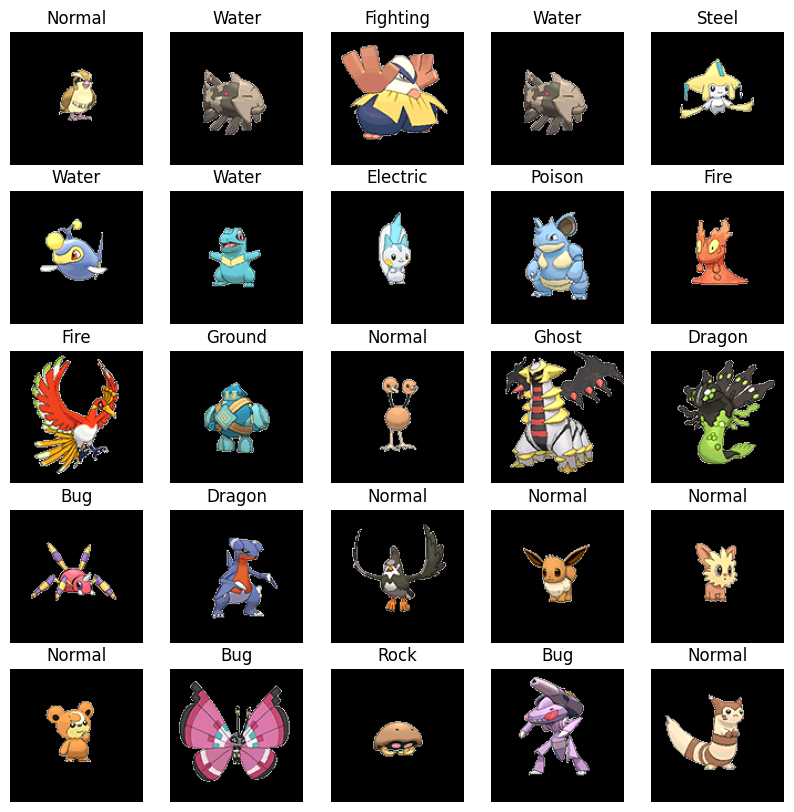

In [12]:

fig, axs = plt.subplots(5,5, figsize=(10,10))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(full_dataset)-1)
        img, lab = full_dataset[ix]
        ax.imshow(((img+1)/2).permute(1,2,0))
        ax.axis('off')
        ax.set_title(classes[lab])
plt.show()

# **Función NOISE SCHEDULER**
Esta función nos permitirá generar ruido.

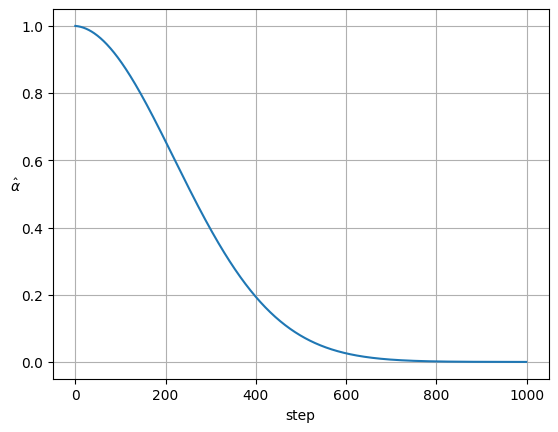

In [13]:
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	betas = torch.linspace(start, end, steps)
	alphas = 1. - betas
	alphas_hat = torch.cumprod(alphas, axis=0)
	return betas, alphas, alphas_hat

_, _, alphas_hat = noise_scheduler()

plt.plot(alphas_hat)
plt.xlabel('step')
plt.ylabel('$\\hat{\\alpha}$', rotation=0)
plt.grid()
plt.show()

In [14]:
class Dataset(torch.utils.data.Dataset):
	def __init__(self, X, T=1000):
		self.X = X
		self.T = T
		self.betas, self.alphas, self.alphas_hat = noise_scheduler(steps=T)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, ix):
		im = self.X[ix][0] #imagen original
		t = torch.randint(0, self.T, (1,))
		y = torch.tensor([self.X[ix][1]])
		noise = torch.randn_like(im) # ruido
		x = noise * torch.sqrt(1 - self.alphas_hat[t]) + im * torch.sqrt(self.alphas_hat[t]) # imagen con ruido
		return x.float(), noise.float(), t, y

In [28]:
ds = Dataset(full_dataset)
img,noise,t,y = ds[2]
img.shape,noise.shape,t.shape,y.shape

(torch.Size([3, 120, 120]),
 torch.Size([3, 120, 120]),
 torch.Size([1]),
 torch.Size([1]))

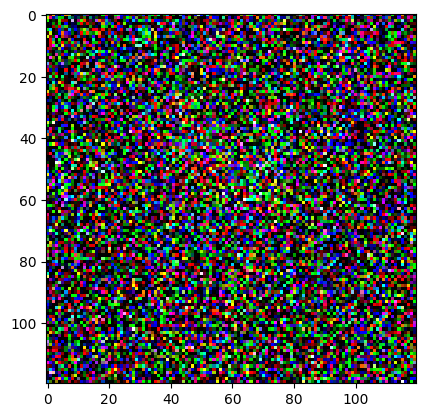

In [30]:
import matplotlib.pyplot as plt
import torch

noise = noise/2
result_image = (img - noise)

result_image = torch.clamp(result_image, 0, 1)

plt.imshow(result_image.permute(1, 2, 0))
plt.show()


In [17]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


In [18]:

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )


class EncoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            conv3x3_bn(ci, co),
            conv3x3_bn(co, co),
        )
        self.embed = torch.nn.Linear(embed_dim, co)

    def forward(self, x, t):
        x = self.conv(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e


class DecoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
        self.embed = torch.nn.Linear(embed_dim, co)

    def forward(self, x1, x2, t):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e


class UNet2(torch.nn.Module):
    def __init__(self, out_ch=3, in_ch=1, embed_dim=32):
        super().__init__()
        # lista de capas en encoder-decoder con número de filtros
        c = [64, 128, 256, 512]
        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(in_ch, c[0]),
            conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = EncoderConv(c[0], c[1], embed_dim)
        self.conv3 = EncoderConv(c[1], c[2], embed_dim)
        self.conv4 = EncoderConv(c[2], c[3], embed_dim)
        # capas del decoder
        self.deconv1 = DecoderConv(c[3], c[2], embed_dim)
        self.deconv2 = DecoderConv(c[2], c[1], embed_dim)
        self.deconv3 = DecoderConv(c[1], c[0], embed_dim)
        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], out_ch, 3, padding=1)

    def forward(self, x, t):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1, t)
        x3 = self.conv3(x2, t)
        x = self.conv4(x3, t)
        # decoder
        x = self.deconv1(x, x3, t)
        x = self.deconv2(x, x2, t)
        x = self.deconv3(x, x1, t)
        x = self.out(x)
        return x

In [19]:
class ConditionalDiffusionModel2(torch.nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(embed_dim)
        self.label_embed = torch.nn.Linear(18, embed_dim)
        self.unet = UNet2(in_ch=3, out_ch=3, embed_dim=embed_dim)

    def forward(self, x, t, y=None):
        B, C, H, W = x.shape
        t = self.time_embed(t)
        if y is not None:
            y = torch.nn.functional.one_hot(y, 18).float()
            y = self.label_embed(y)
            t = t + y
        return self.unet(x, t)

In [20]:
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
im, noise, t, y = next(iter(dl))
im.shape, noise.shape, t.shape, y.shape

(torch.Size([32, 3, 120, 120]),
 torch.Size([32, 3, 120, 120]),
 torch.Size([32, 1]),
 torch.Size([32, 1]))

In [21]:

EPOCHS = 40
model = ConditionalDiffusionModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True, pin_memory=True)
model.train()
for epoch in range(1, EPOCHS+1):
    losses = []
    pb = tqdm.tqdm(dl)
    for im, noise, t, y in pb:
        im, noise, t, y = im.cuda(), noise.cuda(), t.cuda().squeeze(-1), y.cuda().squeeze(-1)
        if np.random.rand() < 0.1:
            y = None
        output = model(im, t, y)
        loss = torch.nn.functional.mse_loss(output, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')
    torch.save(model, f'DDPM_{epoch}.pt')


Epoch 40/40 loss 0.02929: 100%|██████████| 23/23 [00:08<00:00,  2.87it/s]


In [22]:

def sample():
	model.eval()
	x = torch.randn(1, 3, 120, 120).cuda()
	y = 1
	cfg = 0.5
	r, c = 4, 5
	fig = plt.figure(figsize=(15,15))
	i = 0
	for t in reversed(range(ds.T)):
		with torch.no_grad():
			output = model(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
			#output_uncond = model(x, torch.tensor([t]).cuda(), None)
			#output  = torch.lerp(output_uncond, output, cfg)
		if t > 0:
			noise = torch.randn_like(x)
		else:
			noise = torch.zeros_like(x)
		# algoritmo para restar el ruido de manera progresiva propuesto en el paper
		x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])
		if t % 50 == 0:
			i += 1
			ax = plt.subplot(r, c, i)
			#x[0] = torch.nn.Tanh()(x[0])
			ax.imshow(((x[0].cpu()+1)/2).permute(1,2,0))
			ax.axis("off")
			ax.set_title(t)
	print((x[0].max(),x[0].min()))
	plt.tight_layout()
	plt.show()

(tensor(2.0741, device='cuda:0'), tensor(-1.6110, device='cuda:0'))


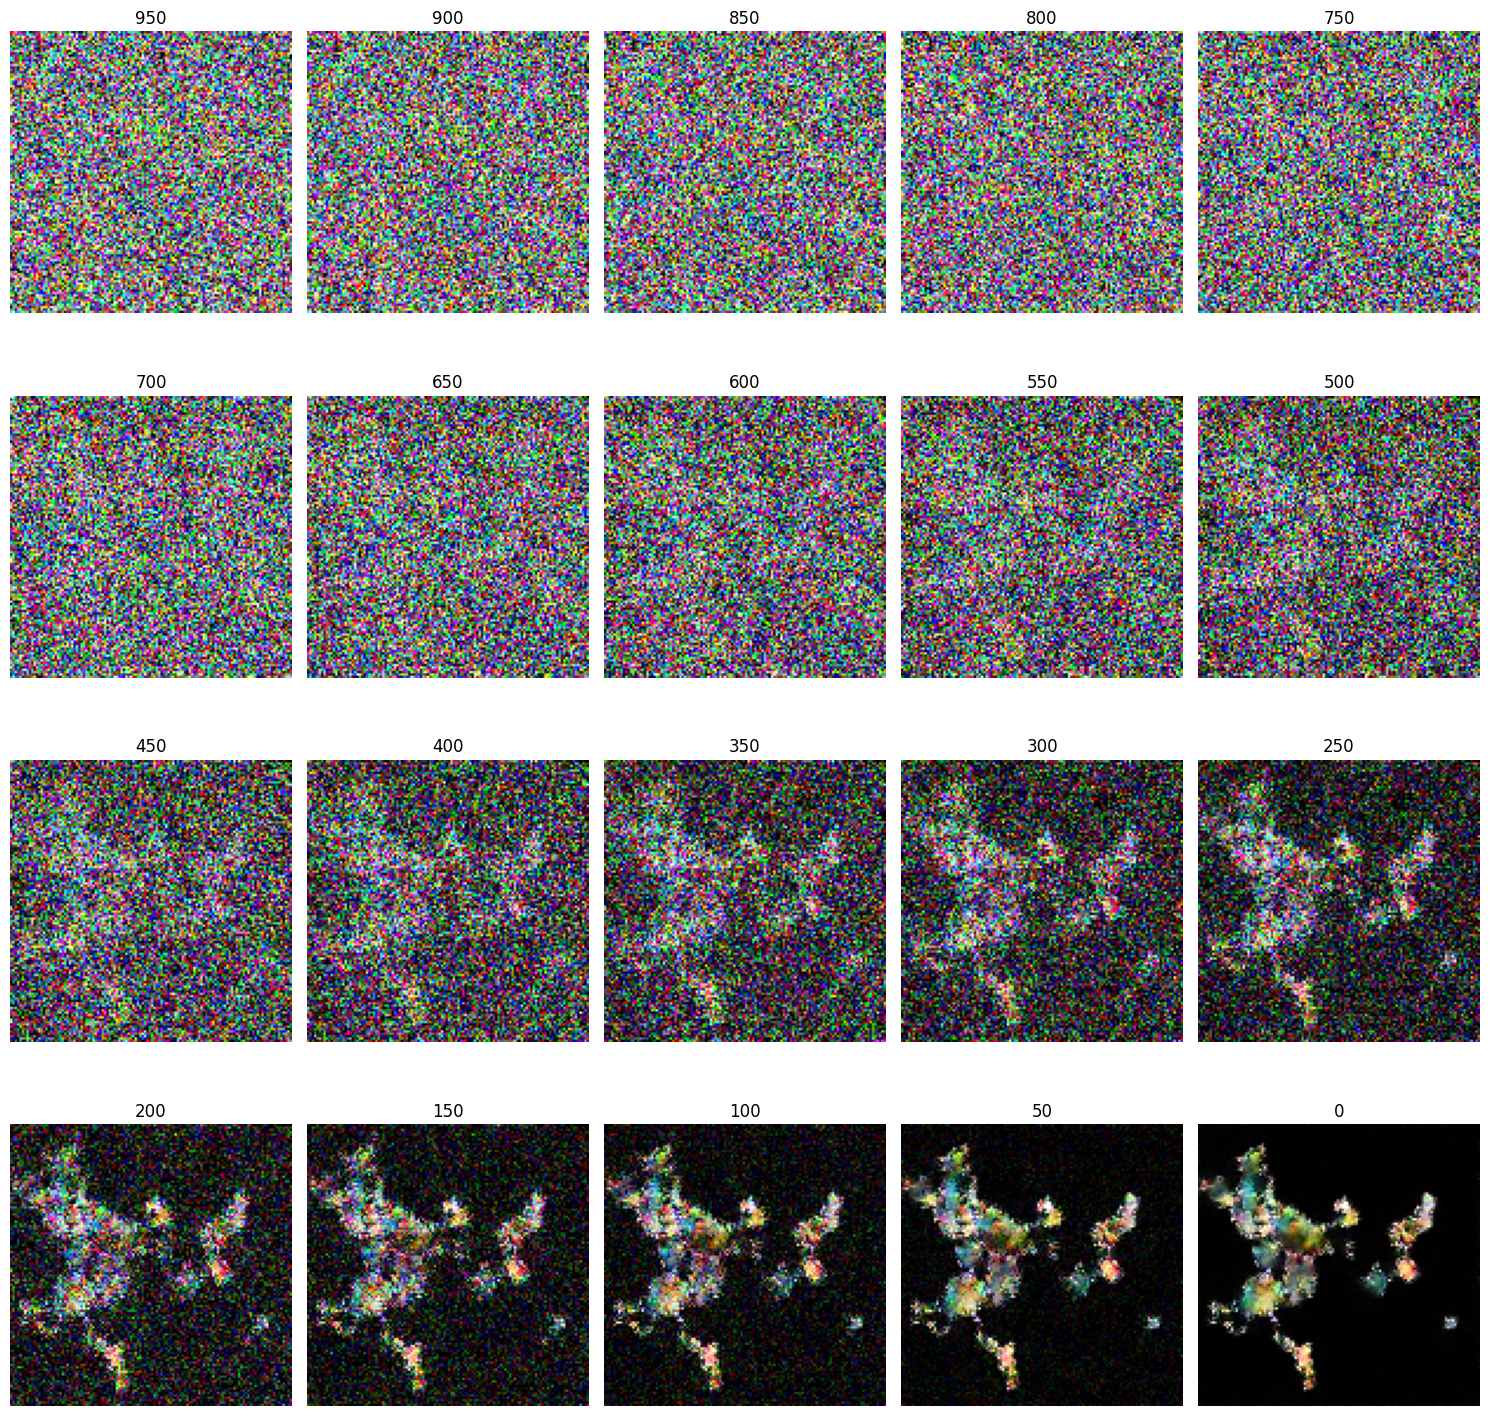

In [23]:

sample()

In [24]:

def generar(label=0):
    model.eval()
    r, c = 5, 5
    fig = plt.figure(figsize=(15,15))
    for i in range(r*c):
        x = torch.randn(1, 3, 120, 120).cuda()
        y = label
        for t in reversed(range(ds.T)):
            with torch.no_grad():
                output = model(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])
        ax = plt.subplot(r, c, i + 1)
        ax.imshow(((x[0].cpu()+1)/2).permute(1,2,0))
        #imgs = torch.nn.Sigmoid()(x[0])
        #ax.imshow(imgs.permute(1,2,0).cpu())
        ax.axis("off")
    plt.tight_layout()
    plt.show()

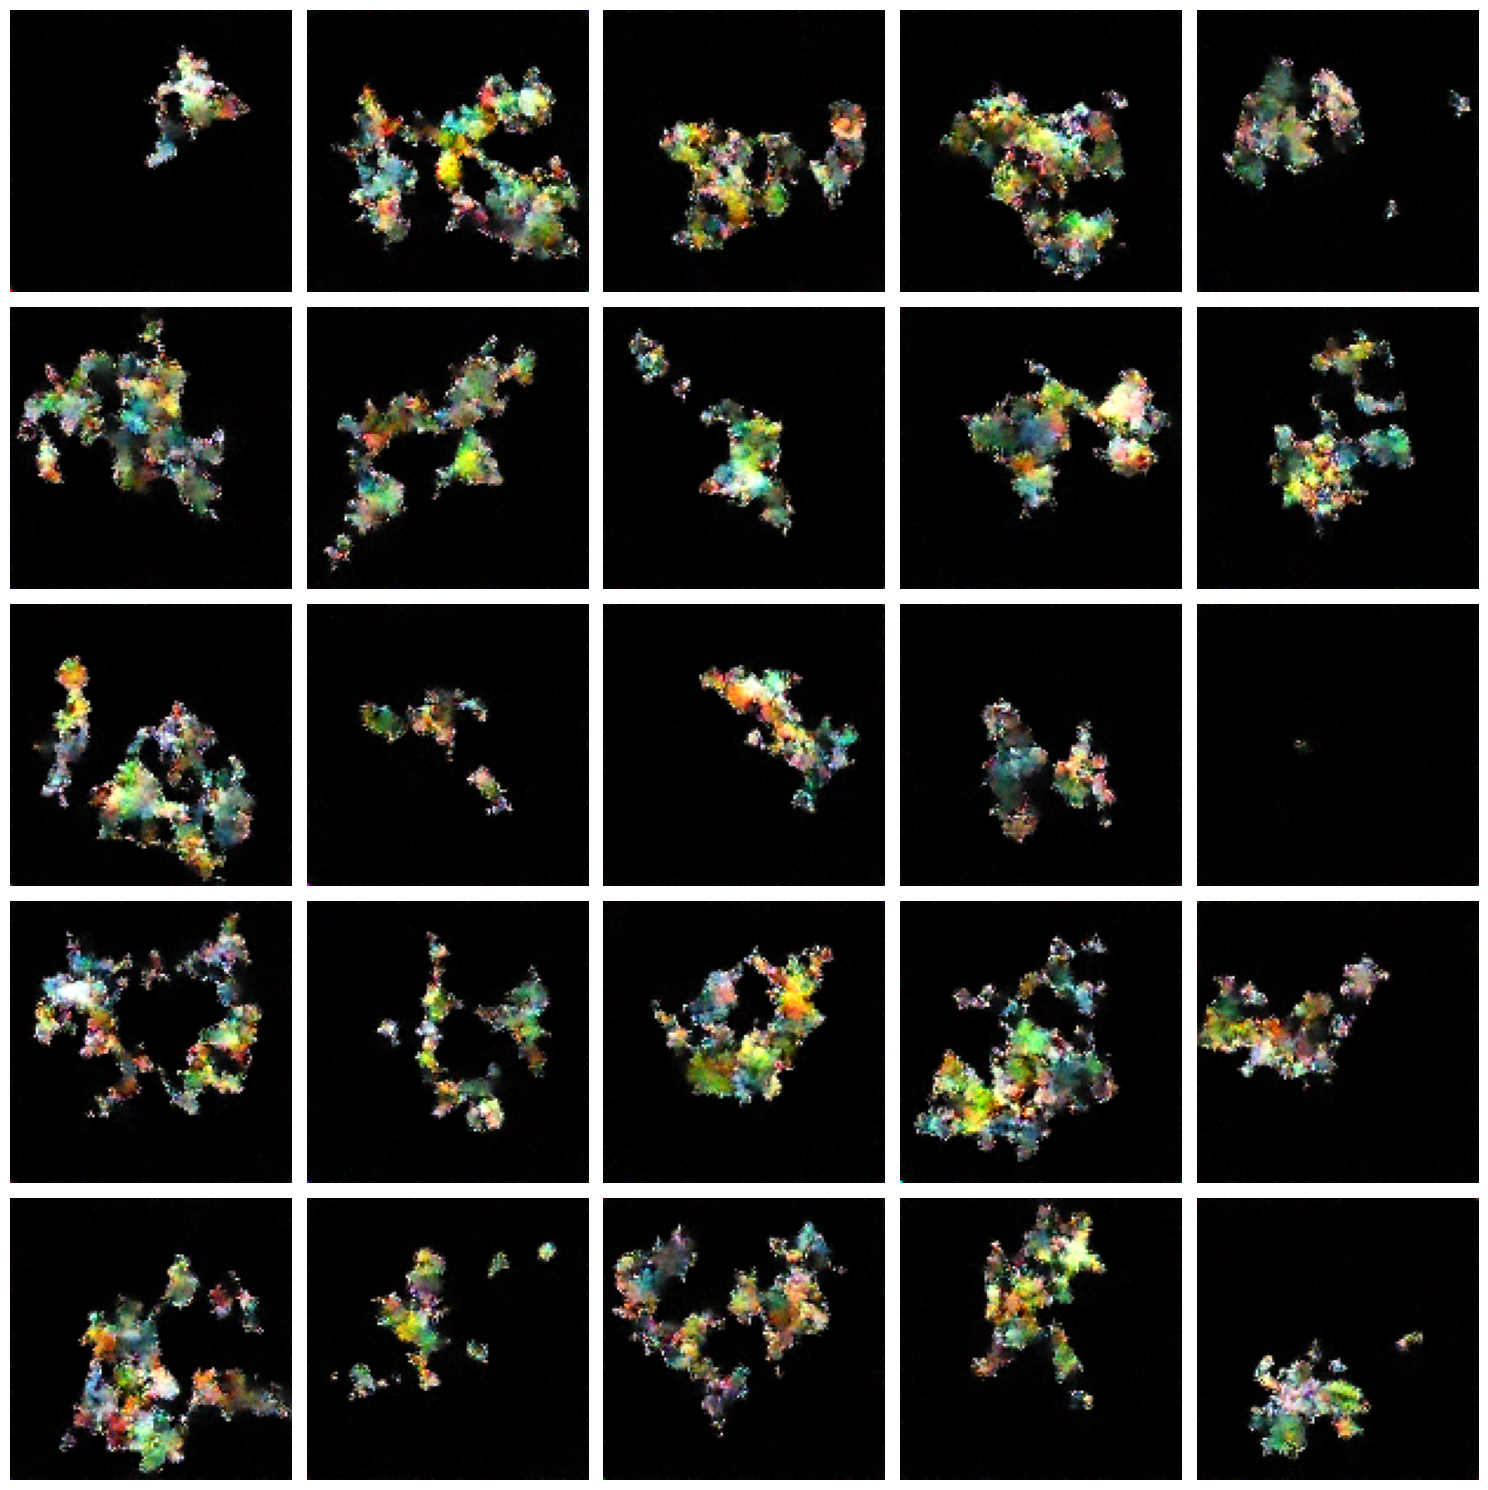

In [25]:
generar(1)